In [1]:
import json
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/voter-behavior-prediction-LLM/

/content/drive/MyDrive/voter-behavior-prediction-LLM


In [4]:
# Function to normalize candidate names to a common format
def normalize_candidate_name(name):
    name = name.lower()
    if 'kılıçdaroğlu' in name:
        return 'kılıçdaroğlu'
    elif 'erdoğan' in name:
        return 'erdoğan'
    return name

In [5]:
# Function to load predictions from a JSON file
def load_predictions(file_name):
    with open(file_name, 'r', encoding='utf-8') as file:
        predictions = json.load(file)
    return predictions

In [6]:
# Function to prepare the predictions DataFrame
def prepare_predictions_df(predictions):
    return pd.DataFrame([
        {'username': user, 'prompt1': pred['prompt1'], 'prompt2': pred['prompt2'], 'prompt3': pred['prompt3']}
        for user, pred in predictions.items()
    ])

In [7]:
# Function to evaluate performance for each prompt
def evaluate_performance(merged_data, prompt_column):
    true_labels = merged_data['true_candidate']
    predicted_labels = merged_data[prompt_column]

    # Calculate precision, recall, and F1 score using sklearn
    precision = precision_score(true_labels, predicted_labels, labels=['kılıçdaroğlu', 'erdoğan'], average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, labels=['kılıçdaroğlu', 'erdoğan'], average='weighted')
    f1 = f1_score(true_labels, predicted_labels, labels=['kılıçdaroğlu', 'erdoğan'], average='weighted')

    print(f"Performance for {prompt_column}:")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=['kılıçdaroğlu', 'erdoğan'])

    # Print the confusion matrix
    print(f"Confusion Matrix for {prompt_column}:")
    print(cm)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Kemal Kılıçdaroğlu', 'Recep Tayyip Erdoğan'])
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, ax=ax)

    # Annotate the confusion matrix with counts, but only where the count is greater than zero
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0:
                plt.text(j, i, f'{cm[i, j]}', ha='center', va='center', color='black')

    plt.title(f"Confusion Matrix for {prompt_column}")
    plt.show()

    return precision, recall, f1

In [8]:
# Main function to process predictions and evaluate performance
def process_and_evaluate(file_name, survey_file='survey.xlsx', prompts=['prompt1', 'prompt2', 'prompt3']):
    # Load predictions
    predictions = load_predictions(file_name)

    # Prepare the predictions DataFrame
    predictions_df = prepare_predictions_df(predictions)

    # Load survey data
    df_survey_data = pd.read_excel(survey_file)
    print("Survey data loaded successfully.")

    # Ensure the 'username' in combined_samples is the correct column name to join on
    merged_data = df_survey_data.merge(predictions_df, on='username', how='right')

    # Normalize the candidate names in both true and predicted labels
    merged_data['true_candidate'] = merged_data['CB 2. Tur'].apply(normalize_candidate_name)  # Adjust this to your actual true labels column name
    for prompt in prompts:
        merged_data[prompt] = merged_data[prompt].apply(normalize_candidate_name)

    # Evaluate performance for each specified prompt and collect metrics
    metrics = []
    for prompt in prompts:
        print(f"Evaluating {prompt} for {file_name.split('_')[1]}")
        precision, recall, f1 = evaluate_performance(merged_data, prompt)
        metrics.append({
            'Model': file_name.split('_')[1],
            'Prompt': prompt,
            'Precision (Macro)': precision,
            'Recall (Macro)': recall,
            'F1-Score (Macro)': f1
        })

    return metrics

Survey data loaded successfully.
Evaluating prompt1 for gpt-3.5-turbo-0125
Performance for prompt1:
Precision: 0.6778852964573323
Recall: 0.5414364640883977
F1 Score: 0.4355149396183564
Confusion Matrix for prompt1:
[[10 81]
 [ 2 88]]


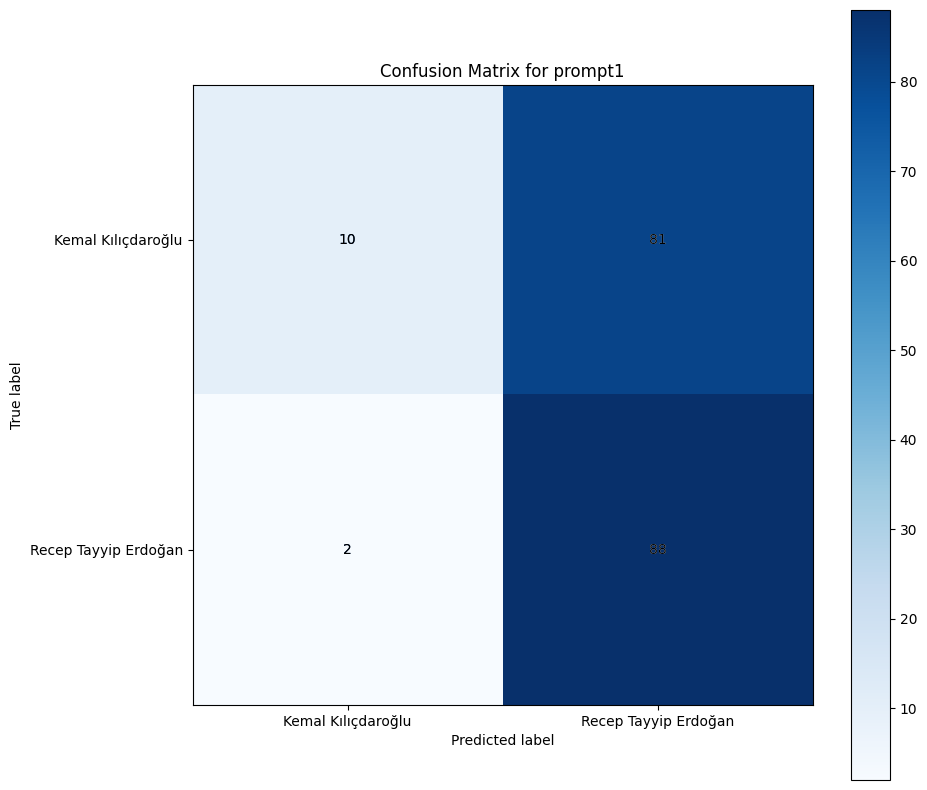

Evaluating prompt2 for gpt-3.5-turbo-0125
Performance for prompt2:
Precision: 0.7089088397790055
Recall: 0.7016574585635359
F1 Score: 0.7028528965138443
Confusion Matrix for prompt2:
[[59 32]
 [21 68]]


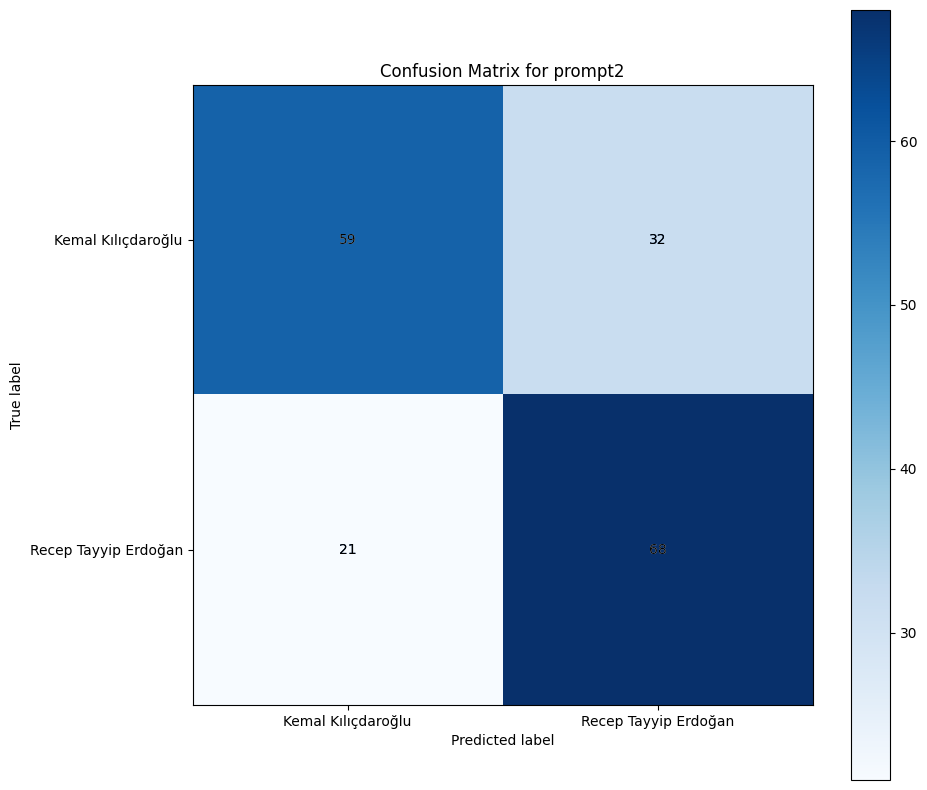

Evaluating prompt3 for gpt-3.5-turbo-0125
Performance for prompt3:
Precision: 0.6964039791967078
Recall: 0.6961325966850829
F1 Score: 0.6960769382175832
Confusion Matrix for prompt3:
[[62 29]
 [26 64]]


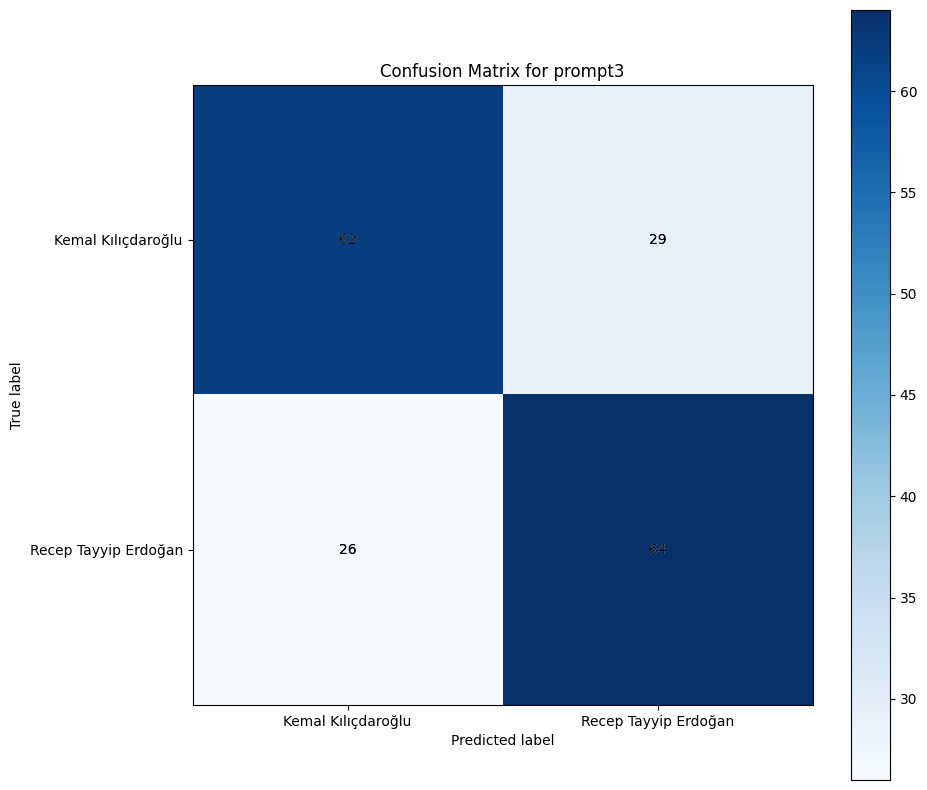

Survey data loaded successfully.
Evaluating prompt1 for gpt-4o-2024-05-13
Performance for prompt1:
Precision: 0.5480219208210121
Recall: 0.5469613259668509
F1 Score: 0.543166471343267
Confusion Matrix for prompt1:
[[58 33]
 [49 41]]


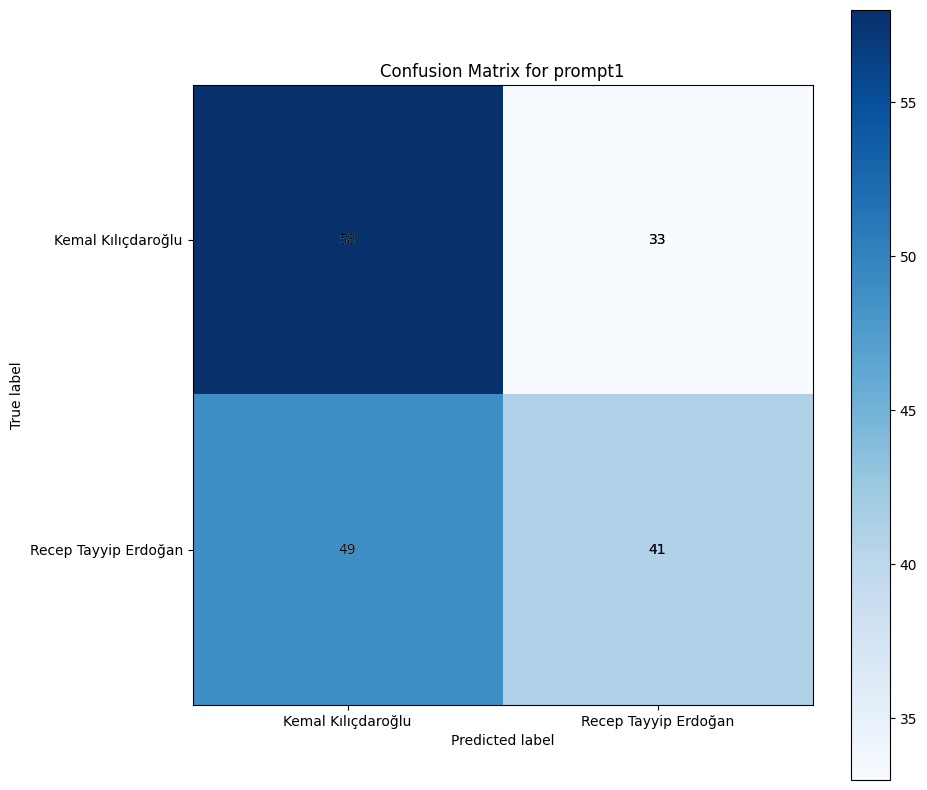

Evaluating prompt2 for gpt-4o-2024-05-13
Performance for prompt2:
Precision: 0.7639096242903737
Recall: 0.7624309392265194
F1 Score: 0.7620240557998038
Confusion Matrix for prompt2:
[[73 18]
 [25 65]]


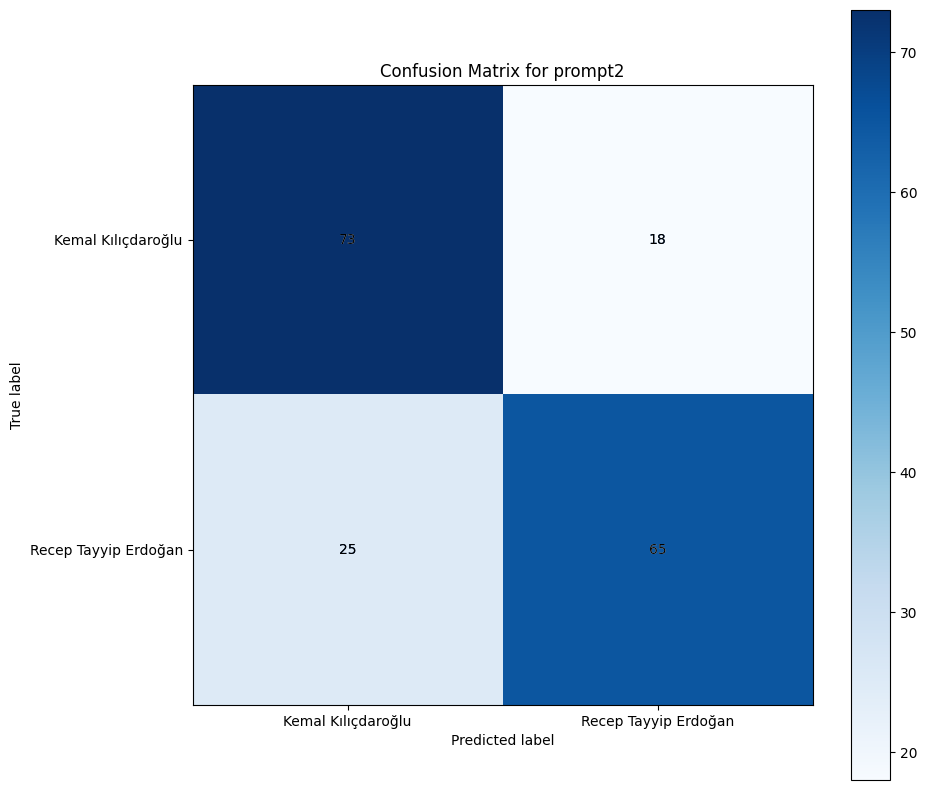

Evaluating prompt3 for gpt-4o-2024-05-13
Performance for prompt3:
Precision: 0.8139368325453002
Recall: 0.7513812154696132
F1 Score: 0.7783141426477862
Confusion Matrix for prompt3:
[[74 11]
 [21 62]]


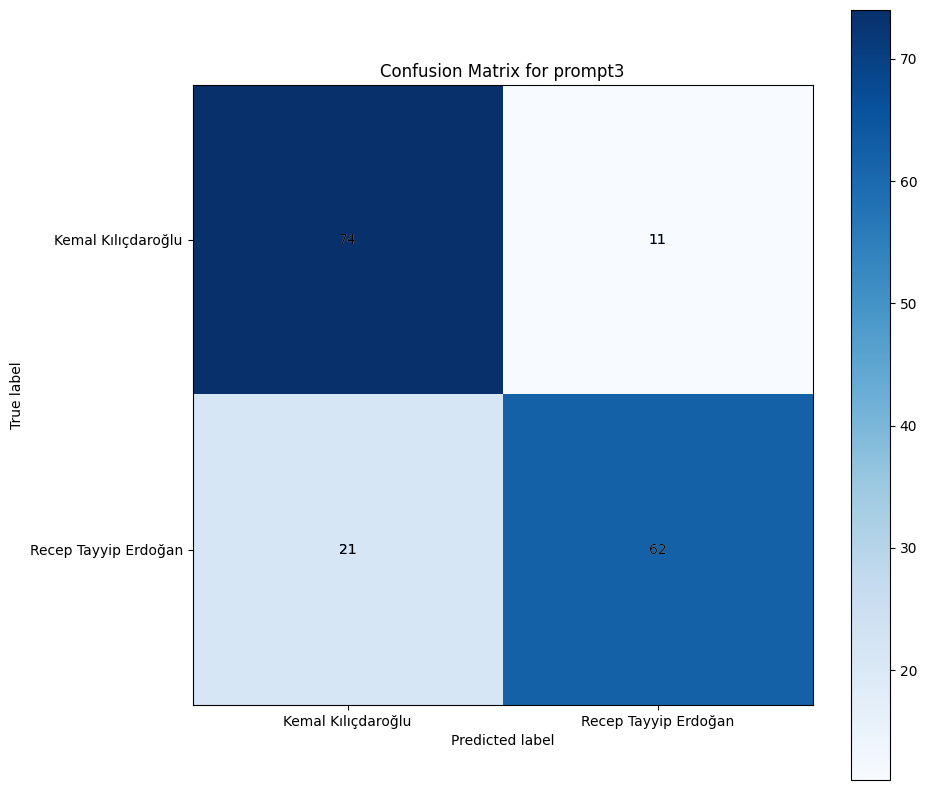

In [9]:
# Process and evaluate for both files with specified prompts
metrics_3_5 = process_and_evaluate('results_gpt-3.5-turbo-0125_20240519153306.json', prompts=['prompt1', 'prompt2', 'prompt3'])
metrics_4 = process_and_evaluate('results_gpt-4o-2024-05-13_20240519155949.json', prompts=['prompt1', 'prompt2', 'prompt3'])

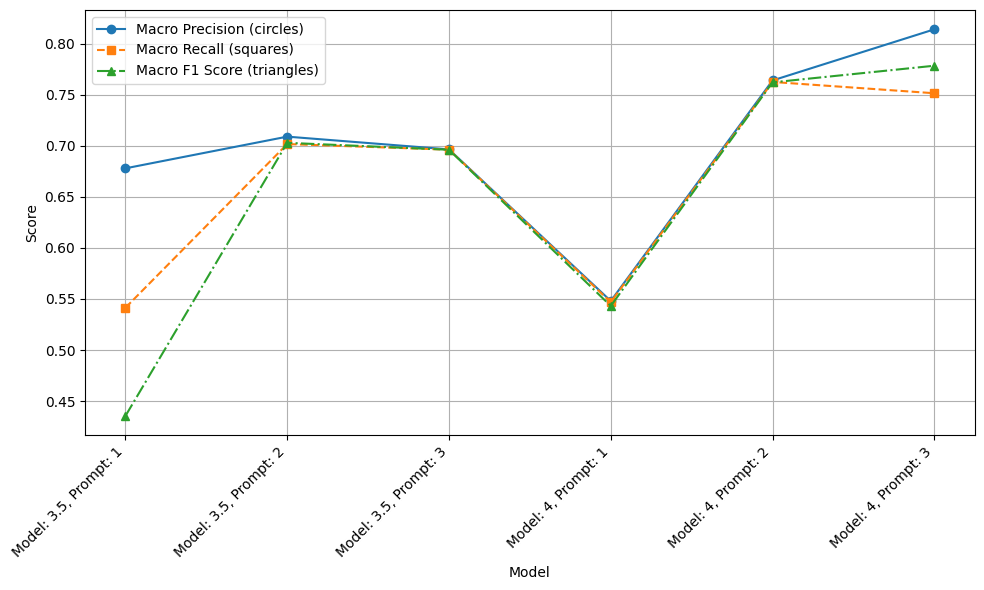

In [10]:
# Combine metrics from both evaluations into a single DataFrame
all_metrics = metrics_3_5 + metrics_4
metrics_df = pd.DataFrame(all_metrics)

# Replace model names with desired labels
categories = [
    'Model: 3.5, Prompt: 1',
    'Model: 3.5, Prompt: 2',
    'Model: 3.5, Prompt: 3',
    'Model: 4, Prompt: 1',
    'Model: 4, Prompt: 2',
    'Model: 4, Prompt: 3'
]

# Extracting data for macro metrics
macro_precision = metrics_df['Precision (Macro)']
macro_recall = metrics_df['Recall (Macro)']
macro_f1_score = metrics_df['F1-Score (Macro)']

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(categories, macro_precision, linestyle='-', marker='o', label='Macro Precision (circles)')
plt.plot(categories, macro_recall, linestyle='--', marker='s', label='Macro Recall (squares)')
plt.plot(categories, macro_f1_score, linestyle='-.', marker='^', label='Macro F1 Score (triangles)')

# Customizing the plot
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('macro_metrics_comparison.png')

plt.show()